In [1]:
from IPython.display import display, HTML

import pandas as pd

from jinja2 import Template

from bokeh.models import (
    ColumnDataSource, Plot, Circle, Range1d, 
    LinearAxis, HoverTool, Text,
    SingleIntervalTicker,
)
from bokeh.models.actions import Callback
from bokeh.models.widgets import Slider
from bokeh.palettes import Spectral6
from bokeh.plotting import vplot
from bokeh.resources import Resources
from bokeh.embed import file_html

from data import process_data

### Setting up the data
The plot animates with the slider showing the data over time from 1964 to 2013. We can think of each year as a seperate static plot, and when the slider moves, we use the Callback to change the data source that is driving the plot.

We could use bokeh-server to drive this change, but as the data is not too big we can also pass all the datasets to the javascript at once and switch between them on the client side.

This means that we need to build one data source for each year that we have data for and are going to switch between using the slider. We build them and add them to a dictionary `sources` that holds them under a key that is the name of the year preficed with a `_`.

In [2]:
fertility_df, life_expectancy_df, population_df_size, regions_df, years, regions = process_data()

sources = {}

region_color = regions_df['region_color']
region_color.name = 'region_color'

for year in years:
    fertility = fertility_df[year]
    fertility.name = 'fertility'
    life = life_expectancy_df[year]
    life.name = 'life' 
    population = population_df_size[year]
    population.name = 'population' 
    new_df = pd.concat([fertility, life, population, region_color], axis=1)
    sources['_' + str(year)] = ColumnDataSource(new_df)

sources looks like this

```
{'_1964': <bokeh.models.sources.ColumnDataSource at 0x7f7e7d165cc0>,
 '_1965': <bokeh.models.sources.ColumnDataSource at 0x7f7e7d165b00>,
 '_1966': <bokeh.models.sources.ColumnDataSource at 0x7f7e7d1656a0>,
 '_1967': <bokeh.models.sources.ColumnDataSource at 0x7f7e7d165ef0>,
 '_1968': <bokeh.models.sources.ColumnDataSource at 0x7f7e7e9dac18>,
 '_1969': <bokeh.models.sources.ColumnDataSource at 0x7f7e7e9da9b0>,
 '_1970': <bokeh.models.sources.ColumnDataSource at 0x7f7e7e9da668>,
 '_1971': <bokeh.models.sources.ColumnDataSource at 0x7f7e7e9da0f0>...

```
 
We will pass this dictionary to the Callback. In doing so, we will find that in our javascript we have an object called, for example _1964 that refers to our ColumnDataSource. Note that we needed the prefixing _ as JS objects cannot begin with a number.

Finally we construct a string that we can insert into our javascript code to define an object.

The string looks like this: `{1962: _1962, 1963: _1963, ....}`

Note the keys of this object are integers and the values are the references to our ColumnDataSources from above. So that now, in our JS code, we have an object that's storing all of our ColumnDataSources and we can look them up. 

In [3]:
dictionary_of_sources = dict(zip([x for x in years], ['_%s' % x for x in years]))
js_source_array = str(dictionary_of_sources).replace("'", "")

### Build the plot

In [4]:
# Set up the plot
xdr = Range1d(1, 9)
ydr = Range1d(20, 100)
plot = Plot(
    x_range=xdr,
    y_range=ydr,
    title="",
    plot_width=800,
    plot_height=400,
    outline_line_color=None,
    toolbar_location=None,    
)
AXIS_FORMATS = dict(
    minor_tick_in=None,
    minor_tick_out=None,
    major_tick_in=None,
    major_label_text_font_size="10pt",
    major_label_text_font_style="normal",
    axis_label_text_font_size="10pt",

    axis_line_color='#AAAAAA',
    major_tick_line_color='#AAAAAA',
    major_label_text_color='#666666',

    major_tick_line_cap="round",
    axis_line_cap="round",
    axis_line_width=1,
    major_tick_line_width=1,
)

xaxis = LinearAxis(SingleIntervalTicker(interval=1), axis_label="Children per woman (total fertility)", **AXIS_FORMATS)
yaxis = LinearAxis(SingleIntervalTicker(interval=20), axis_label="Life expectancy at birth (years)", **AXIS_FORMATS)   
plot.add_layout(xaxis, 'below')
plot.add_layout(yaxis, 'left')

### Add the background year text
We add this first so it is below all the other glyphs

In [5]:
# Add the year in background (add before circle)
text_source = ColumnDataSource({'year': ['%s' % years[0]]})
text = Text(x=2, y=35, text='year', text_font_size='150pt', text_color='#EEEEEE')
plot.add_glyph(text_source, text)

### Add the bubbles and hover
We add the bubbles using the Circle glyph. We start from the first year of data and that is our source that drives the circles (the other sources will be used later).

plot.add_glyph returns the renderer, and we pass this to the HoverTool so that hover only happens for the bubbles on the page and not other glyph elements.

In [6]:
# Add the circle
renderer_source = sources['_%s' % years[0]]
circle_glyph = Circle(
    x='fertility', y='life', size='population',
    fill_color='region_color', fill_alpha=0.8, 
    line_color='#7c7e71', line_width=0.5, line_alpha=0.5)
circle_renderer = plot.add_glyph(renderer_source, circle_glyph)

# Add the hover (only against the circle and not other plot elements)
tooltips = "@index"
plot.add_tools(HoverTool(tooltips=tooltips, renderers=[circle_renderer]))

### Add the legend

Finally we manually build the legend by adding circles and texts to the upper-right portion of the plot.

In [7]:
text_x = 7
text_y = 95
for i, region in enumerate(regions):
    plot.add_glyph(Text(x=text_x, y=text_y, text=[region], text_font_size='10pt', text_color='#666666'))
    plot.add_glyph(Circle(x=text_x - 0.1, y=text_y + 2, fill_color=Spectral6[i], size=10, line_color=None, fill_alpha=0.8))
    text_y = text_y - 5 

### Add the slider and callback
Last, but not least, we add the slider widget and the JS callback code which changes the data of the renderer_source (powering the bubbles / circles) and the data of the text_source (powering background text). After we've set() the `data` we need to trigger() a `change`. slider, renderer_source, text_source are all available because we add them as args to Callback.

It is the combination of `sources = %s % (js_source_array)` in the JS and `Callback(args=sources...)` that provides the ability to look-up, by year, the JS version of our python-made ColumnDataSource.

In [8]:
# Add the slider
code = """
    var year = slider.get('value'),
        sources = %s,
        new_source_data = sources[year].get('data');
    renderer_source.set('data', new_source_data);
    renderer_source.trigger('change');
    text_source.set('data', {'year': [String(year)]});
    text_source.trigger('change');
""" % js_source_array

callback = Callback(args=sources, code=code)
slider = Slider(start=years[0], end=years[-1], value=1, step=1, title="Year", callback=callback, name='testy')
callback.args["slider"] = slider
callback.args["renderer_source"] = renderer_source
callback.args["text_source"] = text_source

## Embed in a template and render
Last but not least, we use vplot to stick togethre the chart and the slider. And we embed that in a template we write using the script, div output from components.

We display it in IPython and save it as an html file.


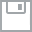
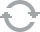
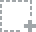
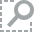
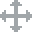
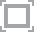
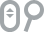

In [9]:
# Stick the plot and the slider together
layout = vplot(plot, slider)

# Open our custom template
with open('gapminder_template.jade', 'r') as f:
    template = Template(f.read())

# Use inline resources
resources = Resources(mode='inline')    
template_variables = {
   'bokeh_min_js': resources.js_raw[0]
}
html = file_html(layout, resources, "Bokeh - Gapminder Bubble Plot", template=template, template_variables=template_variables)

display(HTML(html))